<a href="https://colab.research.google.com/github/jmk9/PyTorch_seminar/blob/master/Autoencoder/JH_pytorch_visualization_trial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [0]:
# Fashion MNIST 데이터셋
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

mnist_data = datasets.FashionMNIST(root = 'data', transform=transform)
mnist_data = list(mnist_data)[:4096]

In [0]:
conv = nn.Conv2d(in_channels=8,
                 out_channels=8,
                 kernel_size=5)

In [25]:
x = torch.randn(2, 8, 64, 64)
y = conv(x)
y.shape

torch.Size([2, 8, 60, 60])

In [26]:
convt = nn.ConvTranspose2d(in_channels=8,
                           out_channels=8,
                           kernel_size=5)
convt(y).shape # should be same as x.shape

torch.Size([2, 8, 64, 64])

In [27]:
x = torch.randn(32, 8, 64, 64)
y = convt(x)
y.shape

torch.Size([32, 8, 68, 68])

In [28]:
conv = nn.Conv2d(in_channels=8,
                 out_channels=16,
                 kernel_size=5)
y = torch.randn(32, 8, 68, 68)
x = conv(y)
x.shape

torch.Size([32, 16, 64, 64])

In [29]:
convt = nn.ConvTranspose2d(in_channels=16,
                           out_channels=8,
                           kernel_size=5,
                           padding=2)
x = torch.randn(32, 16, 64, 64)
y = convt(x)
y.shape

torch.Size([32, 8, 64, 64])

In [30]:
convt = nn.ConvTranspose2d(in_channels=16,
                           out_channels=8,
                           kernel_size=5,
                           stride=2,
                           output_padding=1, # needed because stride=2
                           padding=2)
x = torch.randn(32, 16, 64, 64)
y = convt(x)
y.shape

torch.Size([32, 8, 128, 128])

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, label = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [33]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0734
Epoch:2, Loss:0.0445
Epoch:3, Loss:0.0301
Epoch:4, Loss:0.0247
Epoch:5, Loss:0.0222
Epoch:6, Loss:0.0201
Epoch:7, Loss:0.0192
Epoch:8, Loss:0.0164
Epoch:9, Loss:0.0164
Epoch:10, Loss:0.0147
Epoch:11, Loss:0.0172
Epoch:12, Loss:0.0143
Epoch:13, Loss:0.0180
Epoch:14, Loss:0.0136
Epoch:15, Loss:0.0128
Epoch:16, Loss:0.0150
Epoch:17, Loss:0.0124
Epoch:18, Loss:0.0107
Epoch:19, Loss:0.0114
Epoch:20, Loss:0.0116


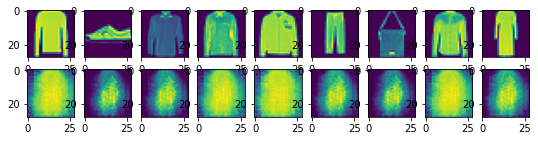

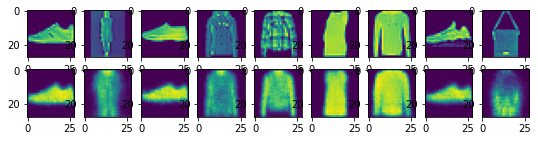

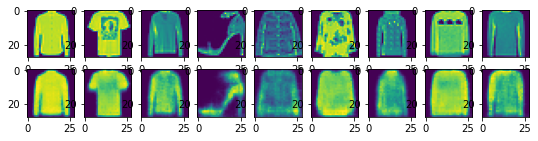

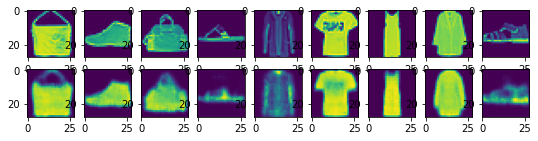

In [34]:
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

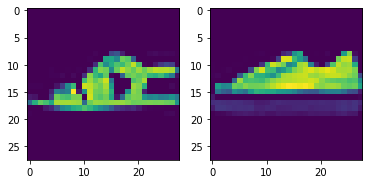

In [35]:
imgs = outputs[max_epochs-1][1].detach().numpy()
plt.subplot(1, 2, 1)
plt.imshow(imgs[0][0])
plt.subplot(1, 2, 2)
plt.imshow(imgs[8][0])

In [0]:
x1 = outputs[max_epochs-1][1][0,:,:,:] # first image
x2 = outputs[max_epochs-1][1][8,:,:,:] # second image
x = torch.stack([x1,x2])     # stack them together so we only call `encoder` once
embedding = model.encoder(x)
e1 = embedding[0] # embedding of first image
e2 = embedding[1] # embedding of second image

In [0]:
embedding_values = []
for i in range(0, 10):
    e = e1 * (i/10) + e2 * (10-i)/10
    embedding_values.append(e)
embedding_values = torch.stack(embedding_values)

recons = model.decoder(embedding_values)

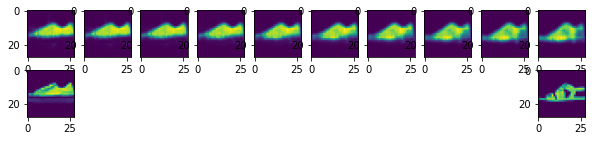

In [38]:
plt.figure(figsize=(10, 2))
for i, recon in enumerate(recons.detach().numpy()):
    plt.subplot(2,10,i+1)
    plt.imshow(recon[0])
plt.subplot(2,10,11)
plt.imshow(imgs[8][0])
plt.subplot(2,10,20)
plt.imshow(imgs[0][0])

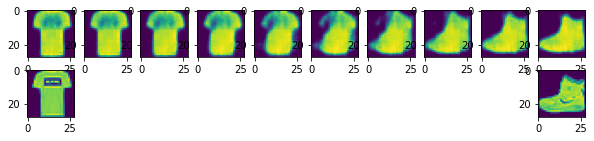

In [39]:
def interpolate(index1, index2):
    x1 = mnist_data[index1][0]
    x2 = mnist_data[index2][0]
    x = torch.stack([x1,x2])
    embedding = model.encoder(x)
    e1 = embedding[0] # embedding of first image
    e2 = embedding[1] # embedding of second image


    embedding_values = []
    for i in range(0, 10):
        e = e1 * (i/10) + e2 * (10-i)/10
        embedding_values.append(e)
    embedding_values = torch.stack(embedding_values)

    recons = model.decoder(embedding_values)

    plt.figure(figsize=(10, 2))
    for i, recon in enumerate(recons.detach().numpy()):
        plt.subplot(2,10,i+1)
        plt.imshow(recon[0])
    plt.subplot(2,10,11)
    plt.imshow(x2[0])
    plt.subplot(2,10,20)
    plt.imshow(x1[0])

interpolate(0, 1)


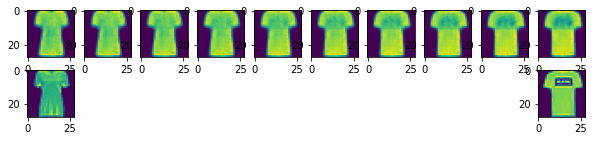

In [40]:
interpolate(1, 10)

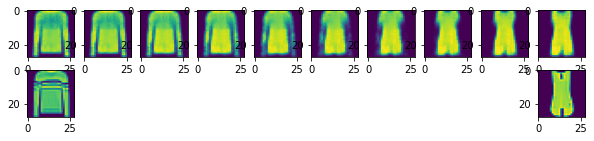

In [41]:
interpolate(4, 5)

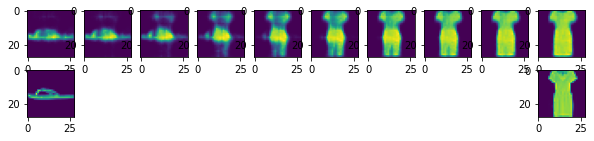

In [42]:
interpolate(20, 30)

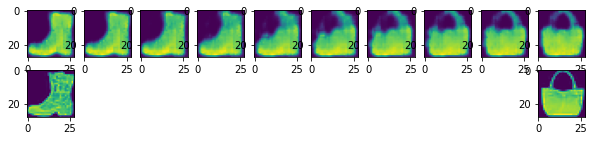

In [43]:
interpolate(100, 150)